In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from math import sqrt

In [2]:
#will connect to database in final version
data = pd.read_csv('Resources/medical_data.csv')
data.head(500)


,animal_type,record_no,status,date,record_type,record_sub_type
0,Cat,M44244776,Completed,23-Mar-18,Surgery,HSWC Spay Resident
1,Cat,M43625283,Completed,2-Feb-18,Surgery,HSWC Spay Resident
2,Cat,M43817874,Completed,30-Jan-18,Surgery,HSWC Spay Resident
3,Cat,M43511736,Completed,25-Jan-18,Surgery,HSWC Neut Resident
4,Cat,M44784946,Completed,3-May-18,Surgery,HSWC Spay Resident
...,...,...,...,...,...,...
495,Cat,M51466359,Completed,24-May-19,Surgery,HSWC Spay Resident
496,Cat,M52063513,Completed,28-Jun-19,Surgery,HSWC Neut Resident
497,Cat,M52063514,Completed,28-Jun-19,Surgery,HSWC Neut Resident
498,Cat,M52063515,Completed,28-Jun-19,Surgery,HSWC Neut Resident


In [3]:
#drop columns we don't need
df = data.drop(['record_no','status','record_type'], axis = 1)
df.head()

,animal_type,date,record_sub_type
0,Cat,23-Mar-18,HSWC Spay Resident
1,Cat,2-Feb-18,HSWC Spay Resident
2,Cat,30-Jan-18,HSWC Spay Resident
3,Cat,25-Jan-18,HSWC Neut Resident
4,Cat,3-May-18,HSWC Spay Resident


In [4]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   animal_type      1177 non-null   object        
 1   date             1177 non-null   datetime64[ns]
 2   record_sub_type  1177 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 27.7+ KB


In [5]:
#get month/year from date

df['month_year'] = df['date'].dt.strftime('%Y-%m')
#df.head(100)
df.dtypes

animal_type                object
date               datetime64[ns]
record_sub_type            object
month_year                 object
dtype: object

In [6]:
#Drop old date column
df = df.drop(['date'], axis = 1)
df.head()

,animal_type,record_sub_type,month_year
0,Cat,HSWC Spay Resident,2018-03
1,Cat,HSWC Spay Resident,2018-02
2,Cat,HSWC Spay Resident,2018-01
3,Cat,HSWC Neut Resident,2018-01
4,Cat,HSWC Spay Resident,2018-05


In [7]:
#get number of surgeries for each month 

counts = df.groupby(['month_year']).size()
counts


month_year
2018-01    44
2018-02    15
2018-03    36
2018-04    30
2018-05    21
2018-06    35
2018-07    52
2018-08    28
2018-09    53
2018-10    41
2018-11    44
2018-12    35
2019-01    22
2019-02    42
2019-03    43
2019-04     7
2019-05    37
2019-06    34
2019-07    32
2019-08    44
2019-09    19
2019-10    34
2019-11    39
2019-12    30
2020-01    32
2020-02    13
2020-03    39
2020-04    22
2020-05    35
2020-06    29
2020-07    33
2020-08    36
2020-09    24
2020-10    31
2020-11    40
2020-12    26
dtype: int64

C:\Users\drjef\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=29.794556, expected=22.000000
predicted=23.122617, expected=35.000000
predicted=29.805987, expected=29.000000
predicted=25.007105, expected=33.000000
predicted=31.708055, expected=36.000000
predicted=29.439180, expected=24.000000
predicted=34.379528, expected=31.000000
predicted=31.325659, expected=40.000000
predicted=28.443528, expected=26.000000
Test RMSE: 6.725


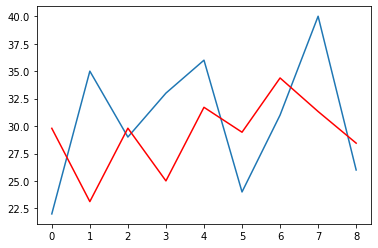

In [33]:
# split into train and test sets
X = counts.values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

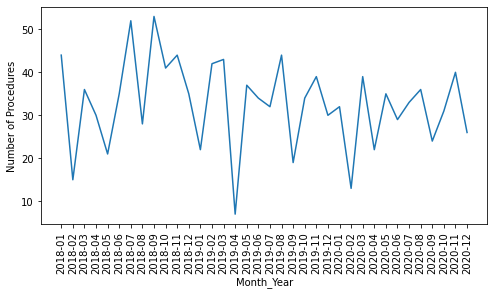

In [34]:
plt.figure(figsize=(8, 4))
plt.xlabel('Month_Year')
plt.ylabel('Number of Procedures')

plt.xticks(rotation=90)

plt.plot(counts)


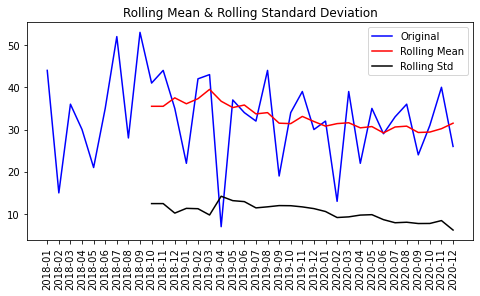

In [35]:
# Deterine if time series is stationary.

rolling_mean = counts.rolling(window = 10).mean()
rolling_std = counts.rolling(window = 10).std()
plt.figure(figsize=(8, 4))
plt.xticks(rotation=90)

plt.plot(counts, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [36]:
counts_df = pd.DataFrame(counts)
counts_df.columns = ['counts']
counts_df.index = pd.to_datetime(counts_df.index)

counts_df

,counts
month_year,
2018-01-01,44
2018-02-01,15
2018-03-01,36
2018-04-01,30
2018-05-01,21
2018-06-01,35
2018-07-01,52
2018-08-01,28
2018-09-01,53


In [37]:
# Dickey-Fuller method of stationary check.

result = adfuller(counts_df['counts'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -4.523442265864301
p-value: 0.00017832531117933361
Critical Values:
	1%: -3.639224104416853
	5%: -2.9512301791166293
	10%: -2.614446989619377


C:\Users\drjef\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\drjef\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provi

(array([17532., 17652., 17775., 17897., 18017., 18140., 18262., 18383.,
        18506., 18628.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

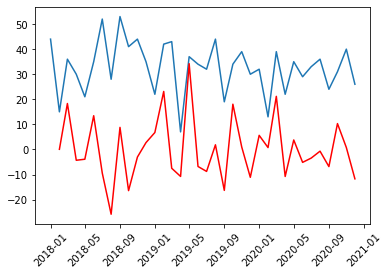

In [38]:
decomposition = seasonal_decompose(counts_df) 
model = ARIMA(counts_df, order=(5,1,0))
results = model.fit(disp=-1)
plt.plot(counts_df)
plt.plot(results.fittedvalues, color='red')
plt.xticks(rotation=45)

(array([17532., 17652., 17775., 17897., 18017., 18140., 18262., 18383.,
        18506., 18628.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

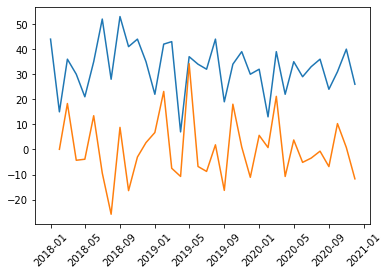

In [39]:
#predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
#predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
#predictions_ARIMA_log = pd.Series(counts_df['counts'].iloc[0], index=counts_df.index)
#predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
#predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(counts_df)
plt.plot(results.fittedvalues)
plt.xticks(rotation=45)

Text(0.5, 0, 'Date')

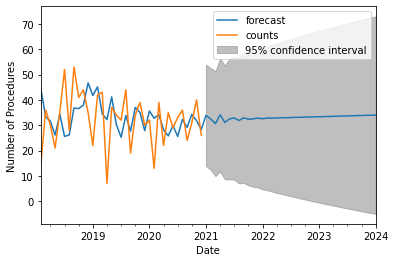

In [43]:
results.plot_predict(1,72)
plt.ylabel('Number of Procedures')
plt.xlabel('Date')